## Load data

In [1]:
# import dependencies for loading data
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob
import numpy as np

Using TensorFlow backend.


In [2]:
# define function to load dataset
def load_dataset(path):
    data = load_files(path)
    x_files = np.array(data['filenames'])
    y_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return x_files, y_targets

#load dataset
x_files, y_targets = load_dataset('data/train')
print('Total number of images: ', len(x_files)) #4750

#load list of categories
categories = [item[11:-1] for item in sorted(glob('data/train/*/'))]
print('List of categories: ', categories)


Total number of images:  4750
List of categories:  ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Data Exploration

### 1. Categorical distribution
To check if the dataset is balanced

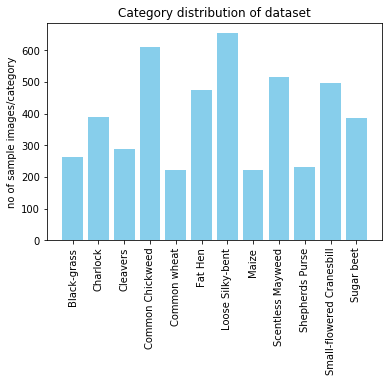

In [4]:
import matplotlib.pyplot as plt
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
category_count = np.sum(y_targets, axis = 0) # count of each class
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count, color ='skyblue')
    ax.set_ylabel('no of sample images/category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()

categorical_dist_graph(categories, category_count)

### 2. Display few sample images from each category

In [3]:
from collections import defaultdict
#creating dict with all categories as key, and their sample images as values

def create_dict(x_files, categories):
    category_dict = defaultdict(list)
    for category in categories:
        for i in range(len(x_files)):
            if category in x_files[i]:
                category_dict[category].append(x_files[i])
    return category_dict
category_dict = create_dict(x_files, categories)

Black-grass


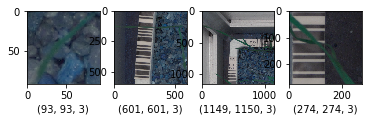

Charlock


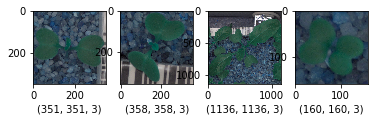

Cleavers


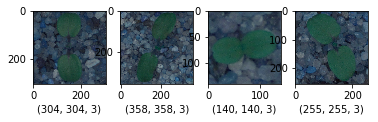

Common Chickweed


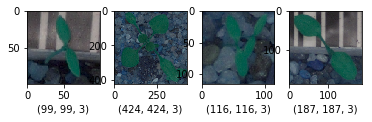

Common wheat


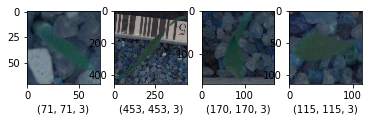

Fat Hen


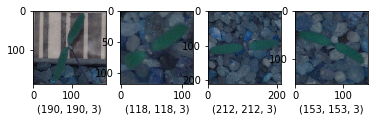

Loose Silky-bent


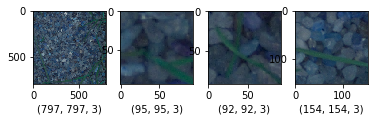

Maize


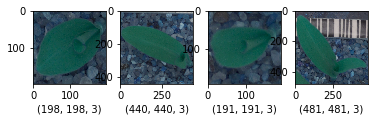

Scentless Mayweed


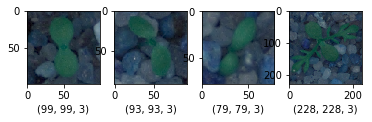

Shepherds Purse


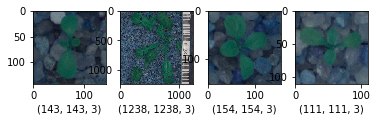

Small-flowered Cranesbill


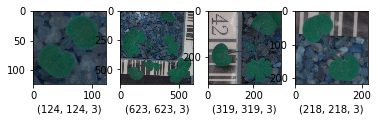

Sugar beet


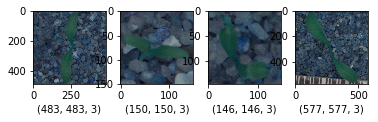

In [6]:
import random
import cv2
def show_sample(n = 3):
    '''
    displays given number of sample images from each of the categories
    '''
    for key in category_dict:
        print(key)
        fig = plt.figure()
        #fig.suptitle(key)
        for i, j in enumerate(random.sample(range(len(category_dict[key])), n)):
            img = cv2.imread(category_dict[key][j])
            fig.add_subplot(1, n, i+1)
            plt.xlabel(img.shape)
            plt.imshow(img)
        plt.show()

show_sample(4)

In [43]:
#Future work
#TODO: Mask background noise, manipulate RGB - HSV

## Train, validation and test split

In [4]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(x_files, y_targets, test_size = 0.15, random_state=32)
print('No of images in training-validation set: ', len(x_train_val))
print('No of images in test set: ', len(x_test))
print('--------------------------------')
print('')
print('Splitting train and validation set: ')
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state=32)
print('No of images in training set: ', len(x_train))
print('No of images in validation set: ', len(x_val))
print('--------------------------------')
print('')
print('Categorical distribution of training set after train-val split: ')
train_dict = create_dict(x_train, categories)
for key in train_dict:
    print(key," : ", len(train_dict[key]))

No of images in training-validation set:  4037
No of images in test set:  713
--------------------------------

Splitting train and validation set: 
No of images in training set:  3229
No of images in validation set:  808
--------------------------------

Categorical distribution of training set after train-val split: 
Black-grass  :  170
Charlock  :  270
Cleavers  :  195
Common Chickweed  :  408
Common wheat  :  144
Fat Hen  :  321
Loose Silky-bent  :  438
Maize  :  158
Scentless Mayweed  :  347
Shepherds Purse  :  157
Small-flowered Cranesbill  :  346
Sugar beet  :  275


### Pre-process data

#### Load train and validation set into tensors

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    ''' 
    loads RGB image as PIL.Image.Image type
    converts PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    converts 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    '''
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train).astype('float32')/255
val_tensors = paths_to_tensor(x_val).astype('float32')/255
test_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|██████████| 713/713 [00:08<00:00, 80.52it/s] 


In [6]:
print(train_tensors.shape)

(3229, 224, 224, 3)


## Performance Metric - F1 score
#### Defining custom metric in Keras

In [7]:
#following has been adapted from - https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
from keras import backend as K
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred, beta =1):
    '''Calculates the f-measure (f1 score), the harmonic mean of precision and recall.
        This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    f1score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return f1score

## Benchmark Model
### A simple CNN architecture

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = (224,224,3)))
#model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(GlobalAveragePooling2D())
#model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(12, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 256)       0         
__________

### Compile and train the benchmark model

In [37]:
from keras.callbacks import ModelCheckpoint  

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score]) # custom metric

epochs = 8

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, y_train, 
          validation_data=(val_tensors, y_val),
          epochs=epochs, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 3229 samples, validate on 808 samples
Epoch 1/8
3229/3229 [==============================] - 602s - loss: 1.6059 - f1score: 0.3268 - val_loss: 1.5360 - val_f1score: 0.3779
Epoch 2/8
3229/3229 [==============================] - 603s - loss: 1.4468 - f1score: 0.3843 - val_loss: 1.3613 - val_f1score: 0.4102
Epoch 3/8
3229/3229 [==============================] - 604s - loss: 1.3786 - f1score: 0.4272 - val_loss: 1.4816 - val_f1score: 0.4223
Epoch 4/8
3229/3229 [==============================] - 605s - loss: 1.2982 - f1score: 0.4800 - val_loss: 1.3112 - val_f1score: 0.4897
Epoch 5/8
3229/3229 [==============================] - 605s - loss: 1.2616 - f1score: 0.4939 - val_loss: 1.1219 - val_f1score: 0.5377
Epoch 6/8
3229/3229 [==============================] - 605s - loss: 1.2115 - f1score: 0.5208 - val_loss: 1.1099 - val_f1score: 0.5782
Epoch 7/8
3229/3229 [==============================] - 607s - loss: 1.1696 - f1score: 0.5509 - val_loss: 1.2923 - val_f1score: 0.5194
Epoch 8/8
3229/

## Testing the benchmark model

In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
'''
    Function to evaluate the performance of the model and confusion matrix
    returns Performance Metric - f1 score
    And confusion matrix
'''
def evaluate_model(model, weights_path, x_tensors, y_tensors):
    model.load_weights(weights_path)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_tensors]
    y_true = np.argmax(y_tensors, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    performance = f1_score(y_true, y_pred, average ='micro')
    return performance, cm

#benchmark_performance = evaluate_model(model, 'saved_models/weights.best.from_scratch.hdf5', test_tensors, y_test)
#print('Performance evaluated by f1 score for the benchmark model is: ', benchmark_performance)
    

#### Performance evaluated by f1 score for the benchmark model is:  0.687237026648

## Model built using Transfer Learning

### Building Model using InceptionV3

In [12]:
# Referred from https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))
# freezing the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation ='relu')(x)
predictions = Dense(12, activation = 'softmax')(x)
model_inception = Model(input=base_model.input, output=predictions)
model_inception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_99 (Conv2D)               (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/home/mnavane/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [13]:
model_inception.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

In [15]:
from keras.callbacks import ModelCheckpoint
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_tlInception.hdf5', 
                               verbose=1, save_best_only=True)

model_inception.fit(train_tensors, y_train, 
          validation_data=(val_tensors, y_val),
          epochs=epochs, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 3229 samples, validate on 808 samples
Epoch 1/10
3229/3229 [==============================] - 365s - loss: 1.4801 - f1score: 0.4628 - val_loss: 2.5343 - val_f1score: 0.1459
Epoch 2/10
3229/3229 [==============================] - 329s - loss: 0.6270 - f1score: 0.7816 - val_loss: 14.4435 - val_f1score: 0.0990
Epoch 3/10
3229/3229 [==============================] - 328s - loss: 0.5038 - f1score: 0.8365 - val_loss: 8.8173 - val_f1score: 0.2646
Epoch 4/10
3229/3229 [==============================] - 330s - loss: 0.3809 - f1score: 0.8742 - val_loss: 2.0307 - val_f1score: 0.7396
Epoch 5/10
3229/3229 [==============================] - 332s - loss: 0.3143 - f1score: 0.8936 - val_loss: 3.3025 - val_f1score: 0.5432
Epoch 6/10
3229/3229 [==============================] - 335s - loss: 0.2644 - f1score: 0.9128 - val_loss: 1.5260 - val_f1score: 0.7409
Epoch 7/10
3229/3229 [==============================] - 334s - loss: 0.2351 - f1score: 0.9273 - val_loss: 0.4402 - val_f1score: 0.8879
Epoch 8

## Evaluating the performance of the model (built using InceptionV3) - F1 score

In [16]:
inc_performance = evaluate_model(model_inception, 'saved_models/weights.best.from_tlInception.hdf5', test_tensors, y_test)
print('Performance evaluated by f1 score for the model created using TL is: ', inc_performance)

Performance evaluated by f1 score for the model created using TL is:  0.88920056101


### Performance evaluated by f1 score for the model created using InceptionV3 is:  0.88920056101

## Building Model using Xception

In [52]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
base_model_xception = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
count =0
for layer in base_model_xception.layers[:75]:
    layer.trainable = False
y = base_model_xception.layers[-50].output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation= 'tanh')(y)
y = Dropout(0.3)(y)
y = Dense(256, activation = 'tanh')(y)
y = Dropout(0.2)(y)
y = Dense(64, activation = 'tanh')(y)
y = Dropout(0.2)(y)
predictions = Dense(12, activation = 'softmax')(y)
model_xception = Model(input=base_model_xception.input, output=predictions)
model_xception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/home/mnavane/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [53]:
model_xception.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

In [54]:
from keras.callbacks import History
history = History()
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_tlXception.hdf5', 
                               verbose=1, save_best_only=True)

hist = model_xception.fit(train_tensors, y_train, 
          validation_data=(val_tensors, y_val),
          epochs=epochs, batch_size=16, callbacks=[checkpointer, history], verbose=1)

Train on 3229 samples, validate on 808 samples
Epoch 1/10
3229/3229 [==============================] - 306s - loss: 1.0858 - f1score: 0.5795 - val_loss: 0.7661 - val_f1score: 0.7461
Epoch 2/10
3229/3229 [==============================] - 304s - loss: 0.4312 - f1score: 0.8544 - val_loss: 0.4355 - val_f1score: 0.8603
Epoch 3/10
3229/3229 [==============================] - 304s - loss: 0.2712 - f1score: 0.9067 - val_loss: 0.3764 - val_f1score: 0.8687
Epoch 4/10
3229/3229 [==============================] - 304s - loss: 0.2119 - f1score: 0.9290 - val_loss: 0.3441 - val_f1score: 0.8909
Epoch 5/10
3229/3229 [==============================] - 304s - loss: 0.1547 - f1score: 0.9498 - val_loss: 0.2853 - val_f1score: 0.9126
Epoch 6/10
3229/3229 [==============================] - 303s - loss: 0.1172 - f1score: 0.9631 - val_loss: 0.3051 - val_f1score: 0.9098
Epoch 7/10
3229/3229 [==============================] - 304s - loss: 0.0880 - f1score: 0.9743 - val_loss: 0.3636 - val_f1score: 0.9100
Epoch 8/

In [55]:
print(hist.history)

{'val_loss': [0.76614748841465108, 0.43546430928872365, 0.37635857611894608, 0.34408180496775276, 0.28532855072529006, 0.30510689408546038, 0.36357621950705971, 0.37313435080986801, 0.56604962854987328, 0.43153509264120299], 'val_f1score': [0.74610620205945311, 0.86034772773780444, 0.86872995430880251, 0.89091871280481316, 0.91260773415612706, 0.90977318570165355, 0.90995150627476151, 0.90266682841990253, 0.86526928915835843, 0.89545933562930269], 'loss': [1.0857585592696672, 0.43118802978365589, 0.27118964917835492, 0.21186560290623613, 0.15466459342138655, 0.1171521143234987, 0.088032648589902757, 0.084016651531797368, 0.065303287974458682, 0.048125009670260614], 'f1score': [0.57950322293541168, 0.85438790172569223, 0.90673062261615089, 0.92900290803740959, 0.94984761219195957, 0.96305587794545189, 0.97430474826816293, 0.97340510649443335, 0.98075903211447724, 0.98680305156075721]}


### Training Vs Validation Loss

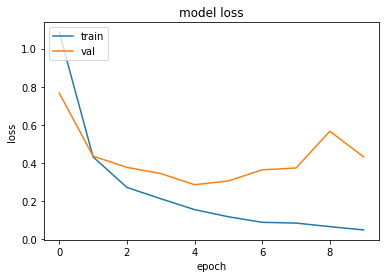

In [57]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Training Vs Validation F1-score

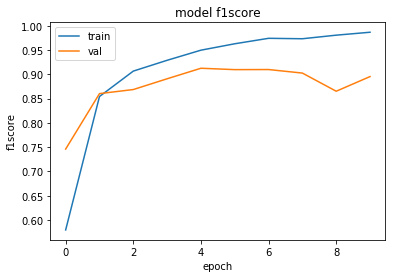

In [56]:
plt.plot(hist.history['f1score'])
plt.plot(hist.history['val_f1score'])
plt.title('model f1score')
plt.ylabel('f1score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
xcep_performance, cm = evaluate_model(model_xception, 'saved_models/weights.best.from_tlXception.hdf5', test_tensors, y_test)
print('Performance evaluated by f1 score for the model created using TL is: ', xcep_performance)

Performance evaluated by f1 score for the model created using TL is:  0.901823281907


### Performance evaluated by f1 score for the model created using Xception is:  0.901823281907

## Plotting Confusion Matrix

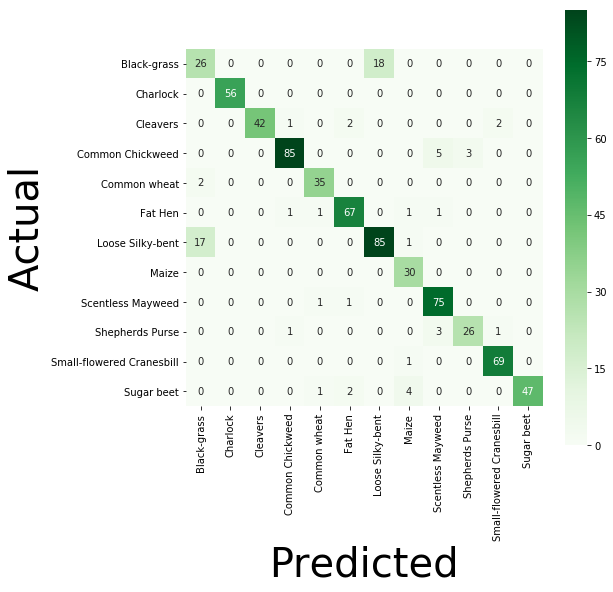

In [25]:
# Referred code from https://www.kaggle.com/xalphahelix/plant-seedlings-classification-cnn
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm_array, figsize):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=categories, yticklabels=categories)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel('Actual', fontsize=40)
    ax.set_xlabel('Predicted', fontsize=40)
    plt.show()

plot_confusion_matrix(cm, (8,8))